In [18]:
import torchvision
import torch
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from zipfile import ZipFile
import random
import PIL
from PIL import Image
import os
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [19]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [8]:
!git clone -b develop https://github.com/sevdaisk/Mushroom-recognition.git

Cloning into 'Mushroom-recognition'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (593/593), done.
remote: Compressing objects: 100% (593/593), done.
remote: Total 4056 (delta 0), reused 592 (delta 0), pack-reused 3463
Receiving objects: 100% (4056/4056), 49.59 MiB | 29.08 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [20]:
input_dir = '/content/Mushroom-recognition'
batch_size = 32
rescale_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
import subprocess
#subprocess.call(['cd', '/content/Mushroom-recognition'])

!rm -r /content/Mushroom-recognition/*.py
!rm -r /content/Mushroom-recognition/.git
!rm -r /content/Mushroom-recognition/.idea
!rm -r /content/Mushroom-recognition/.ipynb_checkpoints

rm: cannot remove '/content/Mushroom-recognition/*.py': No such file or directory
rm: cannot remove '/content/Mushroom-recognition/.git': No such file or directory
rm: cannot remove '/content/Mushroom-recognition/.idea': No such file or directory
rm: cannot remove '/content/Mushroom-recognition/.ipynb_checkpoints': No such file or directory


In [22]:
transform = transforms.Compose([
    transforms.Resize((int(rescale_size), int(rescale_size))),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.8),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
dataset_full = torchvision.datasets.ImageFolder(root=input_dir, transform=transform)

# split full dataset
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.9)
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}
dataset_classes = np.array(dataset_full.classes)
print('classes:', dataset_classes, '\nsize', dataset_size)

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False
    ),
}

classes: ['false honey mushrooms' 'morel' 'panther fly agaric' 'red fly agaric'
 'white toadstool' 'Вешенки' 'Волнушки' 'Желтая сыроежка' 'Желчный гриб'
 'Зеленая сыроежка' 'Красная сыроежка' 'Лисички' 'Маслята' 'Опята'
 'Шампиньоны' 'белый гриб' 'груздь белый' 'груздь черный' 'подберезовик'
 'подосиновик'] 
size {'train': 3600, 'valid': 400}


In [24]:
id2class = {i: cls for i, cls in enumerate(dataset_classes)}

In [25]:
tensorboard_writer = SummaryWriter('./tensorboard_logs')

In [26]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [27]:
from collections import namedtuple
from typing import NamedTuple, List

EvalOut = namedtuple("EvalOut", ['loss', 'accuracy'])
os.makedirs('/content/mushroom_logs', exist_ok=True)

def eval_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.modules.loss._Loss,
    loader: torch.utils.data.DataLoader,
    device: torch.device
):
    acc_loss = 0
    accuracy = 0
    total = len(loader.dataset)
    model.eval()
    model.to(device)
    with torch.inference_mode():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            acc_loss += loss.item()
            accuracy += torch.sum(torch.argmax(pred, 1) == target).item()

    return EvalOut(loss = (acc_loss / total), accuracy = (accuracy / total))


class TrainOut(NamedTuple):
    train_loss: List[float]
    eval_loss: List[float]
    eval_accuracy: List[float]


def train(
    model: torch.nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss._Loss,
    sheduler: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    epochs: int = 10
):
    train_loss = []
    eval_loss = []
    eval_accuracy = []
    model.to(device)
    for i in range(epochs):
        print(f"Epoch - {i}\n")
        if (train_loader != None):
            print("Train...\n")
            train_loss.append(train_epoch(model, optimizer, criterion, train_loader, device))
            tensorboard_writer.add_scalar('loss/training', train_loss[-1], i)
        print("Validation...\n")
        eval_out = eval_epoch(model, criterion, val_loader, device)
        eval_loss.append(eval_out.loss)
        eval_accuracy.append(eval_out.accuracy)
        tensorboard_writer.add_scalar('validation accuracy', eval_out.accuracy, i)
        tensorboard_writer.add_scalar('loss/validation', eval_out.loss, i)
        print(f'Validation acc: {eval_out.accuracy}')
        sheduler.step()
        print('lr: ', get_lr(optimizer))
        if i > 1 and eval_accuracy[i] == max(eval_accuracy) and i % 3 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  }, f'/content/mushroom_logs/epoch_{i}.pth')

    return TrainOut(train_loss = train_loss,
                    eval_loss = eval_loss,
                    eval_accuracy = eval_accuracy), model


In [28]:
def show_losses(TrainOut, epochs):
    plt.plot(epochs, TrainOut.train_loss)
    plt.plot(epochs, TrainOut.eval_loss)
    plt.show()

def show_accuracy(accuracy, epochs):
    plt.plot(epochs, accuracy)
    plt.show()

In [29]:
def predict(model, dataloader_test):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader_test:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [30]:
import torchvision.transforms as T
from torchvision.models import mobilenet_v3_large
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V2')

class MobileNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V2')
    for param in self.mobilenet.parameters():
      param.requires_grad = False

    for j in range(15, 17):
      for param in self.mobilenet.features[j].parameters():
        param.requires_grad = True

    for param in self.mobilenet.classifier.parameters():
      param.requires_grad = True

    self.mobilenet.classifier[3] = torch.nn.Linear(1280, 20)

    self.transforms =  torch.nn.Sequential(
            T.Resize(224),  # We use single int value inside a list due to torchscript type restrictions
#            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x = self.transforms(x)
    y = self.mobilenet(x)
    return y

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 94.3MB/s]


In [31]:
from tqdm.notebook import tqdm

def train_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim,
    criterion: torch.nn.modules.loss._Loss,
    loader: torch.utils.data.DataLoader,
    device: torch.device
):
    acc_loss = 0
    total = len(loader.dataset)
    model.to(device)
    model.train()
    for data, target in tqdm(loader):
      # with accelerator.accumulate(model): # для имитации большого размера батча (полезно для трансформеров)
        data = data.to(device)
        target = target.to(device)
        pred = model(data)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        acc_loss += loss.item()
    for n, (img, pred, label) in enumerate(zip(data, pred, target)):
        if n == 31:
            tensorboard_writer.add_image("testing/{}_GT_{}_pred_{}"
                                          .format(n, id2class[int(label)], id2class[int(torch.argmax(pred, 1))]), img)

    return acc_loss / total


In [32]:
model = MobileNet().to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
epochs = 40
configuration_dict = {'number_of_epochs': epochs, 'batch_size': batch_size, 'base_lr': 1e-4, 'weight_decay': 1e-4, 'rescale_size': 64}
tr_tuple, model = train(model, optimizer, criterion, sheduler, dataloader['train'], dataloader['valid'], device, epochs)

Epoch - 0

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.3125
lr:  9.900000000000001e-05
Epoch - 1

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.465
lr:  9.801e-05
Epoch - 2

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.545
lr:  9.70299e-05
Epoch - 3

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6025
lr:  9.605960100000001e-05
Epoch - 4

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.605
lr:  9.509900499000001e-05
Epoch - 5

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6525
lr:  9.414801494010001e-05
Epoch - 6

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.615
lr:  9.320653479069902e-05
Epoch - 7

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6975
lr:  9.227446944279203e-05
Epoch - 8

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.6775
lr:  9.13517247483641e-05
Epoch - 9

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.69
lr:  9.043820750088047e-05
Epoch - 10

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.72
lr:  8.953382542587167e-05
Epoch - 11

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7075
lr:  8.863848717161295e-05
Epoch - 12

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7175
lr:  8.775210229989682e-05
Epoch - 13

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7325
lr:  8.687458127689785e-05
Epoch - 14

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.745
lr:  8.600583546412887e-05
Epoch - 15

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7675
lr:  8.514577710948758e-05
Epoch - 16

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7725
lr:  8.429431933839271e-05
Epoch - 17

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.785
lr:  8.345137614500879e-05
Epoch - 18

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.78
lr:  8.26168623835587e-05
Epoch - 19

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7625
lr:  8.17906937597231e-05
Epoch - 20

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.745
lr:  8.097278682212587e-05
Epoch - 21

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8075
lr:  8.016305895390461e-05
Epoch - 22

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.77
lr:  7.936142836436556e-05
Epoch - 23

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7575
lr:  7.856781408072191e-05
Epoch - 24

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8075
lr:  7.778213593991469e-05
Epoch - 25

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.7725
lr:  7.700431458051554e-05
Epoch - 26

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8275
lr:  7.623427143471038e-05
Epoch - 27

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.795
lr:  7.547192872036328e-05
Epoch - 28

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8025
lr:  7.471720943315964e-05
Epoch - 29

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8475
lr:  7.397003733882805e-05
Epoch - 30

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8225
lr:  7.323033696543977e-05
Epoch - 31

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.845
lr:  7.249803359578537e-05
Epoch - 32

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8475
lr:  7.177305325982752e-05
Epoch - 33

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8175
lr:  7.105532272722923e-05
Epoch - 34

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.84
lr:  7.034476949995695e-05
Epoch - 35

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.84
lr:  6.964132180495738e-05
Epoch - 36

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8375
lr:  6.89449085869078e-05
Epoch - 37

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8525
lr:  6.825545950103872e-05
Epoch - 38

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.8675
lr:  6.757290490602833e-05
Epoch - 39

Train...



  0%|          | 0/113 [00:00<?, ?it/s]

Validation...

Validation acc: 0.83
lr:  6.689717585696805e-05


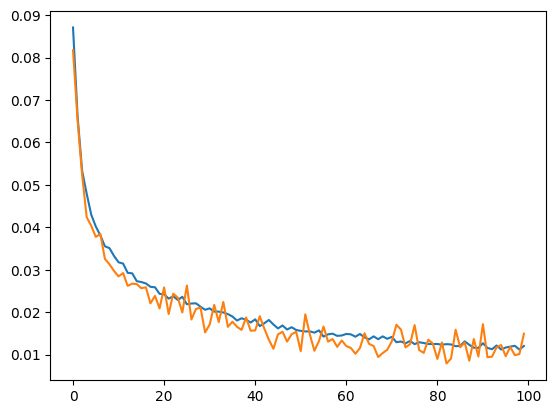

In [ ]:
show_losses(tr_tuple, range(100))

In [33]:
from rembg import remove

class ModelInference:
    def __init__(self, model_path: str, device='cpu'):
        self.device = device
        self.model = MobileNet()
        checkpoint = torch.load(model_path, map_location=torch.device(device))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        self.model.eval()
        self.transforms = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def _remove_background(self, img_path):
        pil_img = Image.open(img_path).convert('RGB')

        # Удаление фона с помощью rembg
        img_without_bg = remove(pil_img).convert('RGB')
        display(img_without_bg)
        return img_without_bg

    def inference(self, img_path='sample.jpg'):
        pil_img = self._remove_background(img_path)
        tensor = self.transforms(pil_img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            preds = self.model(tensor)
            _, predicted = torch.max(preds, 1)
        return id2class[predicted.item()]